In [1]:
%matplotlib inline
import os
import numpy as np

In [2]:

import skimage.io as io
import matplotlib.pyplot as plt
import json



In [3]:
from pycocotools import mask as cocomask
from skimage import measure
from skimage.morphology import dilation, square
from scipy import ndimage
import cv2


In [4]:
image_dir = "/home/fothar/rats/images"
mask_dir = "/home/fothar/rats/masks"
bg_dir = "/home/fothar/rats/back_ground"

video_dir = "/home/fothar/rats/videos"
video_mask_dir = "/home/fothar/rats/video_masks"

val_video_dir = "/home/fothar/rats/val_videos"
val_video_mask_dir = "/home/fothar/rats/val_video_masks"

test_video_dir = "/home/fothar/rats/test_videos"
test_mask_dir = "/home/fothar/rats/test_masks"

In [5]:
cap = cv2.VideoCapture('/home/fothar/rats/rat_sepbg.avi')
frame_id = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:        
        frame = frame[:420, 640:]
        cv2.imwrite(os.path.join(bg_dir, 'bg_{}.png'.format(frame_id)), frame)

        frame_id += 1
    else:
        break

cap.release()

KeyboardInterrupt: 

In [ ]:
def imFunc(e):
  return int(e[3:-4])

def maskFunc(e):
  return int(e[5:-4])

def bgFunc(e):
  return int(e[3:-4])

In [7]:
image_filenames = os.listdir(image_dir)
image_filenames.sort(key=imFunc)

valid_ids = [127, 255]
mask_filenames = os.listdir(mask_dir)
mask_filenames.sort(key=maskFunc)

bg_filenames = os.listdir(bg_dir)
bg_filenames.sort(key=bgFunc)

bg_filenames = bg_filenames[21:]

filenames = zip(image_filenames, mask_filenames, bg_filenames)

vid_idx_list = []

is_vid = False
start_idx = 0
for i, (image_filename, mask_filename, bg_filename)  in enumerate(filenames):
    frame_image = cv2.imread(os.path.join(image_dir, image_filename))
    frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
    
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    blobs_labels = measure.label(frame_mask, background=0)
    
    if np.sum(frame_mask==1)> 0 and np.sum(frame_mask==2)>0:
        if not is_vid:
            start_idx = i
            is_vid = True
    else:
        if is_vid:
            vid_idx_list.append((start_idx, i))
            is_vid = False
            
if is_vid:
    vid_idx_list.append((start_idx, i+1))
    
vid_idx_list = [vid_idx for vid_idx in vid_idx_list if (vid_idx[1] - vid_idx[0] > 10)]
print('len(vid_idx_list)', len(vid_idx_list))

len(vid_idx_list) 152


In [8]:
import math

def circle_sections(divisions, radius=1):
    # the difference between angles in radians -- don't bother with degrees
    angle = 2 * math.pi / divisions

    # a list of all angles using a list comprehension
    angles = [i*angle for i in range(divisions)]

    # finally return the coordinates on the circle as a list of 2-tuples
    return [(radius*math.cos(a), radius*math.sin(a)) for a in angles] 

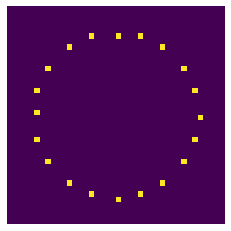

In [9]:
sections = circle_sections(20, 15)

m = np.zeros((40, 40))
center = (20, 20)

for section in sections:
    m[int(center[0]+section[0]), int(center[1]+section[1])] = 1

plt.axis('off')
plt.imshow(m)
plt.show()

In [10]:
def both_rot_augment_frame(frame_image, frame_mask, frame_bg, section):
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    dilated_frame_mask = dilation(frame_mask, square(15))    
    
    center_rat_1 = ndimage.measurements.center_of_mass(frame_mask==1)
    center_rat_2 = ndimage.measurements.center_of_mass(frame_mask==2)    
    move_1 =  (int(center_rat_2[0] - center_rat_1[0] + section[0]),
             int(center_rat_2[1] - center_rat_1[1] + section[1]))
    
    move_2 =  (int(center_rat_2[0] - center_rat_1[0] - section[0]),
             int(center_rat_2[1] - center_rat_1[1] - section[1]))
    
    
    
    moved_mask_1 = (frame_mask==1)
    moved_mask_2 = (frame_mask==2)
    
    def move_mask(moved_mask, move):
        whr0, whr1 = np.where(moved_mask)   

        if (move[0] + max(whr0) + 1) > moved_mask.shape[0]:
            d = min(0, moved_mask.shape[0] - (move[0] + max(whr0) + 1))
        elif (move[0] + min(whr0)) < 0:
            d = max(0, -(move[0] + min(whr0)))
        else:
            d = 0


        move = (move[0] + d, move[1])    
        whr0 = whr0 + move[0]
        whr1 = whr1 + move[1]

        assert max(whr0) < moved_mask.shape[0]
        assert min(whr0) >= 0

        moved_mask[...] = 0    
        moved_mask[whr0, whr1] = 1
        return  moved_mask
    
    moved_mask_1 = move_mask(moved_mask_1, move_1)
    moved_mask_2 = move_mask(moved_mask_2, move_2)
    
    new_mask = np.zeros_like(frame_mask)
    
    new_mask[moved_mask_1==1] = 1
    new_mask[moved_mask_2==1] = 2
     
    #ax[2].imshow(new_mask)
    
    dilated_one_rat_image = frame_image.copy()    
    dilated_one_rat_image[dilated_frame_mask==1] = frame_bg[dilated_frame_mask==1]  
    dilated_one_rat_image[dilated_frame_mask==2] = frame_bg[dilated_frame_mask==2]
    
    dilated_one_rat_image[moved_mask_1==1] = frame_image[frame_mask==1]
    dilated_one_rat_image[moved_mask_2==1] = frame_image[frame_mask==2]
    
    #### blur
    blurred_img = cv2.GaussianBlur(dilated_one_rat_image, (9, 9), 0)
    blur_moved_mask = moved_mask_1.copy().astype(np.uint8)
    blur_mask = moved_mask_1.copy().astype(np.uint8)
    
    blur_mask[blur_mask==1] = 0
    
    contours_moved, _ = cv2.findContours(blur_moved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(blur_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    cv2.drawContours(blur_moved_mask, contours_moved, -1, (13),1)
    cv2.drawContours(blur_mask, contours, -1, (13),1)
    
    blur_moved_mask[frame_mask==2] = 0
    
    blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    blur_mask = np.stack((blur_mask,blur_mask, blur_mask), axis=2)
    cc = blurred_img #np.zeros_like(blurred_img)
    dilated_one_rat_image = np.where(blur_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    dilated_one_rat_image = np.where(blur_moved_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    
    
    return new_mask, dilated_one_rat_image

In [11]:
def rot_augment_frame(frame_image, frame_mask, frame_bg, section):
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    dilated_frame_mask = dilation(frame_mask, square(15))    
    
    center_rat_1 = ndimage.measurements.center_of_mass(frame_mask==1)
    center_rat_2 = ndimage.measurements.center_of_mass(frame_mask==2)    
    move =  (int(center_rat_2[0] - center_rat_1[0] + section[0]),
             int(center_rat_2[1] - center_rat_1[1] + section[1]))
    
    
    
    moved_mask = (frame_mask==1)    
    whr0, whr1 = np.where(moved_mask)   
    
    if (move[0] + max(whr0) + 1) > moved_mask.shape[0]:
        d = min(0, moved_mask.shape[0] - (move[0] + max(whr0) + 1))
    elif (move[0] + min(whr0)) < 0:
        d = max(0, -(move[0] + min(whr0)))
    else:
        d = 0
     
    
    move = (move[0] + d, move[1])    
    whr0 = whr0 + move[0]
    whr1 = whr1 + move[1]
    
    assert max(whr0) < moved_mask.shape[0]
    assert min(whr0) >= 0
    
    moved_mask[...] = 0    
    moved_mask[whr0, whr1] = 1
    
    #ax[0].imshow(frame_image)
    #ax[1].imshow(frame_mask)
    
    new_mask = np.zeros_like(frame_mask)
    
    new_mask[moved_mask==1] = 1
    new_mask[frame_mask==2] = 2
     
    #ax[2].imshow(new_mask)
    
    dilated_one_rat_image = frame_image.copy()    
    dilated_one_rat_image[dilated_frame_mask==1] = frame_bg[dilated_frame_mask==1]  
    dilated_one_rat_image[dilated_frame_mask==2] = frame_bg[dilated_frame_mask==2]
    dilated_one_rat_image[moved_mask==1] = frame_image[frame_mask==1]
    dilated_one_rat_image[frame_mask==2] = frame_image[frame_mask==2]
    
    #### blur
    blurred_img = cv2.GaussianBlur(dilated_one_rat_image, (9, 9), 0)
    blur_moved_mask = moved_mask.copy().astype(np.uint8)
    blur_mask = frame_mask.copy().astype(np.uint8)
    
    blur_mask[blur_mask==1] = 0
    
    contours_moved, _ = cv2.findContours(blur_moved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(blur_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    cv2.drawContours(blur_moved_mask, contours_moved, -1, (13),1)
    cv2.drawContours(blur_mask, contours, -1, (13),1)
    
    blur_moved_mask[frame_mask==2] = 0
    
    blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    blur_mask = np.stack((blur_mask,blur_mask, blur_mask), axis=2)
    cc = blurred_img #np.zeros_like(blurred_img)
    dilated_one_rat_image = np.where(blur_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    dilated_one_rat_image = np.where(blur_moved_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    
    
    return new_mask, dilated_one_rat_image

In [12]:
def follow_augment_frame(frame_image_a, frame_mask_a, frame_bg_a,
                         frame_image_b, frame_mask_b, frame_bg_b,
                         cross, shift_x, shift_y):
    frame_mask_a[frame_mask_a==valid_ids[0]] = 1
    frame_mask_a[frame_mask_a==valid_ids[1]] = 2
    
    frame_mask_b[frame_mask_b==valid_ids[0]] = 1
    frame_mask_b[frame_mask_b==valid_ids[1]] = 2
    
    dilated_frame_mask = dilation(frame_mask_a, square(15))   #???vagy a 
    
    center_rat_1 = ndimage.measurements.center_of_mass(frame_mask_b==1)
    center_rat_2 = ndimage.measurements.center_of_mass(frame_mask_a==1)    
    move =  (int(shift_x),
             int(shift_y))
    
    
    
    moved_mask = (frame_mask_b==1)    
    whr0, whr1 = np.where(moved_mask)   
    
    if (move[0] + max(whr0) + 1) > moved_mask.shape[0]:
        d = min(0, moved_mask.shape[0] - (move[0] + max(whr0) + 1))
    elif (move[0] + min(whr0)) < 0:
        d = max(0, -(move[0] + min(whr0)))
    else:
        d = 0
        
    move = (move[0] + d, move[1])
     
    
        
    #move = (move[0] + d, move[1])
    #if cross:
    #    whr0 = ((whr0 + (move[0] + 1)) - moved_mask.shape[0]) * -1
    #else:
    #    whr0 = whr0 + move[0]        
        
    whr0 = whr0 + move[0]
    
    whr1 = whr1 + move[1]
    assert max(whr0) < moved_mask.shape[0]
    assert min(whr0) >= 0
    
    moved_mask[...] = 0    
    moved_mask[whr0, whr1] = 1
    
    if cross:
        moved_mask = np.flipud(moved_mask)
    
    #ax[0].imshow(frame_image)
    #ax[1].imshow(frame_mask)
    
    new_mask = np.zeros_like(frame_mask_a)
    
    new_mask[frame_mask_a==1] = 2
    new_mask[moved_mask==1] = 1 
    
    
    #ax[2].imshow(new_mask)
    
    dilated_one_rat_image = frame_image_a.copy()    
    dilated_one_rat_image[dilated_frame_mask==2] = frame_bg_a[dilated_frame_mask==2]
    if cross:
        dilated_one_rat_image[moved_mask==1] = np.flipud(frame_image_b)[np.flipud(frame_mask_b)==1]
    else:
        dilated_one_rat_image[moved_mask==1] = frame_image_b[frame_mask_b==1]
    
    #### blur
    blurred_img = cv2.GaussianBlur(dilated_one_rat_image, (9, 9), 0)
    blur_moved_mask = moved_mask.copy().astype(np.uint8)
    blur_mask = frame_mask_a.copy().astype(np.uint8)
    
    blur_mask[blur_mask==2] = 0
    
    contours_moved, _ = cv2.findContours(blur_moved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(blur_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    cv2.drawContours(blur_moved_mask, contours_moved, -1, (13),1)
    cv2.drawContours(blur_mask, contours, -1, (13),1)
    
    blur_mask[moved_mask==1] = 0
    
    blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    blur_mask = np.stack((blur_mask,blur_mask, blur_mask), axis=2)
    cc = blurred_img #np.zeros_like(blurred_img)
    
    dilated_one_rat_image = np.where(blur_moved_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    dilated_one_rat_image = np.where(blur_mask==np.array([13, 13, 13]), cc, dilated_one_rat_image)
    
    return new_mask, dilated_one_rat_image

In [13]:
def coco_segm(gt_mask):
    ground_truth_binary_mask = gt_mask.astype(np.uint8)
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_mask = cocomask.encode(fortran_ground_truth_binary_mask)

    area = cocomask.area(encoded_mask)
    bounding_box = cocomask.toBbox(encoded_mask)
    encoded_mask['counts'] = encoded_mask['counts'].decode('ascii')
    
    return encoded_mask, area.tolist(), bounding_box.tolist()
    

In [22]:
rat_info = dict(description= 'Rats', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
rat_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
rat_categories = [dict(supercategory= 'object', id= 1, name ='rat')]


def annotation_data(vid_idx_list, video_dir, video_mask_dir, augment=True):
    valid_ids = [127, 255]
   
    rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    videos=[],
                    annotations=[])


    ann_id = 1
    for v, vid_idx in enumerate(vid_idx_list):

        vid_id = (v*(1+2)) + 1
        #vid_id = (v*(1+9) + 1

        video = dict(width= 640,
                     length= vid_idx[1]-vid_idx[0],
                     date_captured= '',
                     license= '',
                     flickr_url= '',
                     file_names= [],
                     id= vid_id,
                     coco_url= '',
                     height=420)  

        ann_rat_1 = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= ann_id,
                         areas= [])

        ann_id += 1

        ann_rat_2 = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= ann_id,
                         areas= [])

        ann_id += 1

        vid_path = os.path.join(video_dir, str(vid_id))
        if not os.path.exists(vid_path):
            os.mkdir(vid_path)
        vid_mask_path=os.path.join(video_mask_dir, str(vid_id))
        if not os.path.exists(vid_mask_path):
            os.mkdir(vid_mask_path)



        video_files = zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])

        for f, (image_filename, mask_filename, bg_filename) in enumerate(video_files): 
            frame_image = cv2.imread(os.path.join(image_dir, image_filename))
            frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
            frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))


            video['file_names'].append(os.path.join(str(vid_id), '{}.png'.format(f)))

            encoded_mask1, area1, bbox1 = coco_segm((frame_mask==valid_ids[0]).astype(np.uint8))
            ann_rat_1['segmentations'].append(encoded_mask1)
            ann_rat_1['bboxes'].append(bbox1)
            ann_rat_1['areas'].append(area1)

            encoded_mask2, area2, bbox2 = coco_segm((frame_mask==valid_ids[1]).astype(np.uint8))
            ann_rat_2['segmentations'].append(encoded_mask2)
            ann_rat_2['bboxes'].append(bbox2)
            ann_rat_2['areas'].append(area2)       


            cv2.imwrite(os.path.join(vid_path, '{}.png'.format(f)), frame_image)
            cv2.imwrite(os.path.join(vid_mask_path, '{}.png'.format(f)), frame_mask)       

        rat_data['videos'].append(video)
        rat_data['annotations'].append(ann_rat_1)
        rat_data['annotations'].append(ann_rat_2)

        ### AUGMENT
        if augment:
            
            augmentations = [dict(aug='rad', rad=20),
                             dict(aug='rad', rad=60),
                             dict(aug='follow', delay=10, shift_x=10, shift_y=10),
                             
                             dict(aug='follow', delay=15, shift_x=10, shift_y=-20),
                             dict(aug='follow', delay=10, shift_x=-20, shift_y=-20),
                             dict(aug='follow', delay=20, shift_x=-25, shift_y=20),
                             
                             dict(aug='follow', delay=30, shift_x=-20, shift_y=20),
                             dict(aug='cross', vertical=True, delay=5, shift_x=-1, shift_y=20),
                             dict(aug='cross', vertical=True, delay=10, shift_x=-20, shift_y=20)]
                  
            augmentations = [dict(aug='both_rad', rad=40),
                             dict(aug='both_rad', rad=80)]
            
            #augmentations = [dict(aug='cross', vertical=True, delay=5, shift_x=-1, shift_y=20)]
            
            
            aug_vid_id = vid_id + 1
            for aug in augmentations:

                aug_video = dict(width= 640,
                             length= vid_idx[1]-vid_idx[0],
                             date_captured= '',
                             license= '',
                             flickr_url= '',
                             file_names= [],
                             id= aug_vid_id,
                             coco_url= '',
                             height=420)

                aug_ann_rat_1 = dict(height= 420,
                                 width= 640,
                                 length= 1,
                                 category_id= 1,
                                 segmentations= [],
                                 bboxes= [],
                                 video_id= aug_vid_id,
                                 iscrowd= False,
                                 id= ann_id,
                                 areas= [])
                ann_id += 1

                aug_ann_rat_2 = dict(height= 420,
                                 width= 640,
                                 length= 1,
                                 category_id= 1,
                                 segmentations= [],
                                 bboxes= [],
                                 video_id= aug_vid_id,
                                 iscrowd= False,
                                 id= ann_id,
                                 areas= [])
                ann_id += 1

                aug_vid_path = os.path.join(video_dir, 'aug_{}_{}'.format(aug['aug'], aug_vid_id))
                if not os.path.exists(aug_vid_path):
                    os.mkdir(aug_vid_path)
                aug_vid_mask_path=os.path.join(video_mask_dir, 'aug_{}_{}'.format(aug['aug'], aug_vid_id))
                if not os.path.exists(aug_vid_mask_path):
                    os.mkdir(aug_vid_mask_path)


                video_files = [(i, m, b) for i, m, b in zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])]

                if aug['aug']=='rad' or aug['aug']=='both_rad':
                    sections = circle_sections(aug['rad'], aug['rad'])
                    for f, (image_filename, mask_filename, bg_filename) in enumerate(video_files):   
                        frame_image = cv2.imread(os.path.join(image_dir, image_filename))
                        frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
                        frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))
                        section = sections[f%len(sections)]
                        if aug['aug']=='rad':
                            new_mask, dilated_one_rat_image = rot_augment_frame(frame_image, frame_mask, frame_bg, section)
                        else:
                            new_mask, dilated_one_rat_image = both_rot_augment_frame(frame_image, frame_mask, frame_bg, section)
                        encoded_mask, area, bbox = coco_segm(new_mask==1)
                        aug_ann_rat_1['segmentations'].append(encoded_mask)
                        aug_ann_rat_1['bboxes'].append(bbox)
                        aug_ann_rat_1['areas'].append(area)

                        encoded_mask, area, bbox = coco_segm(new_mask==2)
                        aug_ann_rat_2['segmentations'].append(encoded_mask)
                        aug_ann_rat_2['bboxes'].append(bbox)
                        aug_ann_rat_2['areas'].append(area)

                        new_mask[new_mask==1] = valid_ids[0]
                        new_mask[new_mask==2] = valid_ids[1]

                        aug_video['file_names'].append(os.path.join('aug_{}_{}'.format(aug['aug'], aug_vid_id), '{}.png'.format(f)))
                        cv2.imwrite(os.path.join(aug_vid_path, '{}.png'.format(f)), dilated_one_rat_image)
                        cv2.imwrite(os.path.join(aug_vid_mask_path, '{}.png'.format(f)), new_mask)
                elif aug['aug'] in ['follow', 'cross']:
                    video_files_b = ([video_files[0]] * aug['delay']) + video_files
                    video_files_a =  video_files + ([video_files[-1]] * aug['delay'])
                    for f, (files_a, files_b) in enumerate(zip(video_files_a, video_files_b)):   
                        image_filename_a, mask_filename_a, bg_filename_a = files_a
                        image_filename_b, mask_filename_b, bg_filename_b = files_b
                        
                        frame_image_a = cv2.imread(os.path.join(image_dir, image_filename_a))
                        frame_mask_a = cv2.imread(os.path.join(mask_dir, mask_filename_a), 0)
                        frame_bg_a = cv2.imread(os.path.join(bg_dir, bg_filename_a))
                        
                        frame_image_b = cv2.imread(os.path.join(image_dir, image_filename_b))
                        frame_mask_b = cv2.imread(os.path.join(mask_dir, mask_filename_b), 0)
                        frame_bg_b = cv2.imread(os.path.join(bg_dir, bg_filename_b))
                        
                        
                        new_mask, dilated_one_rat_image = follow_augment_frame(frame_image_a,
                                                                               frame_mask_a,
                                                                               frame_bg_a,
                                                                               frame_image_b,
                                                                               frame_mask_b,
                                                                               frame_bg_b,
                                                                               cross=aug['aug']=='cross',
                                                                               shift_x=aug['shift_x'],
                                                                               shift_y=aug['shift_y'])
                        
                        encoded_mask, area, bbox = coco_segm(new_mask==1)
                        aug_ann_rat_1['segmentations'].append(encoded_mask)
                        aug_ann_rat_1['bboxes'].append(bbox)
                        aug_ann_rat_1['areas'].append(area)

                        encoded_mask, area, bbox = coco_segm(new_mask==2)
                        aug_ann_rat_2['segmentations'].append(encoded_mask)
                        aug_ann_rat_2['bboxes'].append(bbox)
                        aug_ann_rat_2['areas'].append(area)

                        new_mask[new_mask==1] = valid_ids[0]
                        new_mask[new_mask==2] = valid_ids[1]

                        aug_video['file_names'].append(os.path.join('aug_{}_{}'.format(aug['aug'], aug_vid_id), '{}.png'.format(f)))
                        cv2.imwrite(os.path.join(aug_vid_path, '{}.png'.format(f)), dilated_one_rat_image)
                        cv2.imwrite(os.path.join(aug_vid_mask_path, '{}.png'.format(f)), new_mask)
                else:
                    asd


                #print('xxxx')
                rat_data['videos'].append(aug_video)    

                rat_data['annotations'].append(aug_ann_rat_1)
                rat_data['annotations'].append(aug_ann_rat_2)
                aug_vid_id += 1

                valid_ids = valid_ids[::-1]
            
    return rat_data

def test_video_data(vid_idx, video_dir, video_mask_dir, vid_length=200):
    rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    videos=[],
                    annotations=[])

    for vid_id, frame_idx in enumerate(list(range(vid_idx, len(image_filenames), vid_length))):
        video = dict(width= 640,
                     length= min(100, len(image_filenames)-frame_idx),
                     date_captured= '',
                     license= '',
                     flickr_url= '',
                     file_names= [],
                     id= vid_id,
                     coco_url= '',
                     height=420) 

        vid_path = os.path.join(video_dir, str(vid_id))
        if not os.path.exists(vid_path):
            os.mkdir(vid_path)
        mask_path = os.path.join(video_mask_dir, str(vid_id))
        if not os.path.exists(mask_path):
            os.mkdir(mask_path)
        
        video_files = zip(image_filenames[frame_idx:frame_idx+min(vid_length, len(image_filenames)-frame_idx)],
                          mask_filenames[frame_idx:frame_idx+min(vid_length, len(image_filenames)-frame_idx)])

        for f, (image_filename, mask_filename) in enumerate(video_files):
            frame_image = cv2.imread(os.path.join(image_dir, image_filename))
            frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename))
            
            video['file_names'].append(os.path.join(str(vid_id), '{}.png'.format(f)))
            cv2.imwrite(os.path.join(vid_path, '{}.png'.format(f)), frame_image)
            cv2.imwrite(os.path.join(mask_path, '{}.png'.format(f)), frame_mask)

        rat_data['videos'].append(video)
    
    ann_rat_test = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= 0,
                         areas= [])
    rat_data['annotations'].append(ann_rat_test)
    
    return rat_data
    

In [ ]:
short_video_dir = "/home/fothar/rats/short_videos"
short_video_mask_dir = "/home/fothar/rats/short_video_masks"

if not os.path.exists(short_video_dir):
    os.mkdir(short_video_dir)
    
if not os.path.exists(short_video_mask_dir):
    os.mkdir(short_video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[:13], short_video_dir, short_video_mask_dir)

with open('/home/fothar/rats/annotations/instances_train_short.json', 'w') as outfile:
    json.dump(ann_data, outfile)

In [ ]:
short_val_video_dir = "/home/fothar/rats/short_val_videos"
short_val_video_mask_dir = "/home/fothar/rats/short_val_video_masks"

if not os.path.exists(short_val_video_dir):
    os.mkdir(short_val_video_dir)
    
if not os.path.exists(short_val_video_mask_dir):
    os.mkdir(short_val_video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[-13:], short_val_video_dir, short_val_video_mask_dir)

with open('/home/fothar/rats/annotations/short_instances_val.json', 'w') as outfile:
    json.dump(ann_data, outfile)

In [ ]:
if not os.path.exists(video_dir):
    os.mkdir(video_dir)
    
if not os.path.exists(video_mask_dir):
    os.mkdir(video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[:130], video_dir, video_mask_dir)

with open('/home/fothar/rats/annotations/instances_train.json', 'w') as outfile:
    json.dump(ann_data, outfile)
    



In [ ]:
if not os.path.exists(val_video_dir):
    os.mkdir(val_video_dir)
    
if not os.path.exists(val_video_mask_dir):
    os.mkdir(val_video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[130:], val_video_dir, val_video_mask_dir)

with open('/home/fothar/rats/annotations/instances_val.json', 'w') as outfile:
    json.dump(ann_data, outfile)

In [23]:


if not os.path.exists(test_video_dir):
    os.mkdir(test_video_dir)
    
if not os.path.exists(test_mask_dir):
    os.mkdir(test_mask_dir)
    
test_data = test_video_data(vid_idx_list[0][0], test_video_dir, test_mask_dir)

with open('/home/fothar/rats/annotations/instances_test.json', 'w') as outfile:
    json.dump(test_data, outfile)

## Test

In [ ]:
from mmdet.datasets import build_dataset

from mmdet.datasets.rats import RatsDataset

In [ ]:
dataset_type = 'RatsDataset'
data_root = '/home/fothar/rats/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

        
yt_data = RatsDataset(ann_file=data_root + 'annotations/instances_train.json',
        img_prefix=data_root + 'videos',
        img_scale=(640, 420),
        img_norm_cfg=img_norm_cfg,
        size_divisor=32,
        flip_ratio=0.5,
        with_mask=True,
        with_crowd=True,
        with_label=True,
        with_track=True)

In [ ]:
xx = yt_data.__getitem__(142)

In [ ]:
xx.keys()

In [ ]:
np.unique(xx['gt_labels'].data)

In [ ]:
np.unique(xx['obj_ids'].data)

In [ ]:
mask = xx['gt_masks'].data
mask.shape

In [ ]:
I = xx['img'].data.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
plt.axis('off')
plt.imshow(mask[0])
plt.show()

In [ ]:
plt.axis('off')
plt.imshow(mask[1])
plt.show()

In [ ]:
2+3

In [ ]:
c = 0
for i in range (4):
    c += len(rat_data['videos'][i]['file_names'])

c


In [ ]:


cap = cv2.VideoCapture('/home/fothar/rats/rat_sepbg_fr20to15020.avi')

test_video_dir = '/home/fothar/rats/test_videos'

test_info = dict(description= 'Rats test', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
test_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
test_categories = [dict(supercategory= 'object', id= 1, name ='rat')]
test_data = dict(info=test_info, 
                licenses=test_licenses,
                categories=test_categories,
                videos=[],
                annotations=[])



vid_frames = []
frame_id = 1
video_id = 1
while(cap.isOpened()):
    
    if frame_id % 5 ==0:
        video = dict(width= 640,
                 length= len(vid_frame),
                 date_captured= '',
                 license= '',
                 flickr_url= '',
                 file_names= [],
                 id= video_id,
                 coco_url= '',
                 height=420)
        
        test_vid_path = os.path.join(test_video_dir, '{}'.format(video_id))
        if not os.path.exists(test_vid_path):
            os.mkdir(test_vid_path)
        for f, vid_frame in enumerate(vid_frames):
            cv2.imwrite(os.path.join(test_vid_path, '{}_{}.png'.format(f, video_id)), vid_frame)
            video['file_names'].append(os.path.join('{}'.format(video_id), '{}_{}.png'.format(f, video_id)))
        
        test_data['videos'].append(video)        
        vid_frames = vid_frames[-1:]
        video_id += 1
    
    ret, frame = cap.read()    
    if ret:
        
        vid_frames.append(frame[:420, :640])
        
        frame_id += 1
    else:
        break

cap.release()

with open('/home/fothar/rats/annotations/instances_test.json', 'w') as outfile:
    json.dump(test_data, outfile)